<a href="https://colab.research.google.com/github/malcolmlett/robovac/blob/main/Experiment_NN_LDS_to_OccupancyMap_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Experiment: NN prediction of Occupancy Map from LDS (v3)
The first version had a number of problems:
* Very slow to execute (takes about 2 mins to train on TPU for just 5 epochs across 1000 samples each)
* Performs very poorly

In v2 of this notebook I looked at different network architectures and concluded that the basic UNet with skip connections merged by concatenation is not considerably slower than any other options and performs with the best results. So I'm going to stick with that for now.

In this notebook I'll experiment with ways to improve the loss function.

In [2]:
import os
if os.path.isdir('repo'):
  # discard any local changes and update
  !cd repo && git reset --hard HEAD
  !cd repo && git fetch
else:
  !git clone https://github.com/malcolmlett/robovac.git repo

# lock to revision
!cd repo && git checkout 63bcc74
#!cd repo && git pull

import sys
sys.path.append('repo')

import lds
import map_from_lds_train_data
import unet
from importlib import reload
reload(lds)
reload(map_from_lds_train_data)
reload(unet)

HEAD is now at cc6875b Initial baseline results showing the class probabilities from our simple default UNet model with the default loss function.
Already up to date.


<module 'unet' from '/content/repo/unet.py'>

In [3]:
!pip install -Uqq ipdb

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image
import io
import cv2
import requests
import math
import ipdb
from timeit import default_timer as timer

In [5]:
floorplan = Image.open('repo/data/experimental-floorplan1.png')
floorplan = np.array(floorplan, dtype=bool)
print(f"floorplan: shape={floorplan.shape}, dtype={floorplan.dtype}")

floorplan: shape=(84, 94), dtype=bool


## Helper functions

In [6]:
def display_history(history):
  plt.figure(figsize=(11,3))
  plt.subplot(1,3,1)
  plt.plot(model_history.history["loss"])
  plt.title("Loss")

  plt.subplot(1,3,2)
  plt.plot(model_history.history["ce"])
  plt.title("Cross-Entropy")

  plt.subplot(1,3,3)
  plt.plot(model_history.history["accuracy"])
  plt.title("Accuracy")
  plt.show()

def show_prediction(display_list, titles):
    plt.figure(figsize=(10, 3))

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(titles[i])
        plt.imshow(display_list[i], cmap='gray')
        plt.axis('off')
    plt.show()

def show_predictions(model, dataset, num=1, show_probs=True):
    """
    Displays the first image of each of the num batches
    """
    for image, ground_truth in dataset.take(num):
        batch = np.expand_dims(image, axis=0)
        batch_pred = model.predict(batch)
        pred = tf.argmax(batch_pred, axis=-1)[0]

        if show_probs:
          # showing full details
          print(f"Class 0 logit range - {tf.reduce_min(batch_pred[..., 0])}, {tf.reduce_max(batch_pred[..., 0])}")
          print(f"Class 1 logit range - {tf.reduce_min(batch_pred[..., 1])}, {tf.reduce_max(batch_pred[..., 1])}")
          #probs = tf.nn.softmax(batch_pred[0], axis=-1)
          probs = batch_pred[0]  # show the raw logits
          class0_prob = probs[:, :, 0]
          class1_prob = probs[:, :, 1]
          show_prediction(
              [image, ground_truth, pred, class0_prob, class1_prob],
              ['LDS Data', 'Ground Truth', 'Predicted', 'Class 0', 'Class 1'])
        else:
          show_prediction([image, ground_truth, pred], ['LDS Data', 'Ground Truth', 'Predicted'])

## Training data
Just fetch the pre-generated training data.

In [8]:
# If generated data is available then load that to save time:
loaded = np.load('repo/data/experimental-lds-training-data1.npz')
X = loaded['X']
Y = loaded['Y']
print(f"X: {len(X)} x {X[0].shape}")
print(f"Y: {len(Y)} x {Y[0].shape}")

# Make available for training
dataset = tf.data.Dataset.from_tensor_slices((X, Y))

X: 1000 x (105, 105)
Y: 1000 x (105, 105)


# Baseline
Setup our simple model.
And then let's get a sample result for a baseline.

In [62]:
data_shape = next(iter(dataset))[0].shape
input_size = (data_shape[0], data_shape[1], 1)
n_filters=32
n_classes=2

model = unet.unet_model(input_size, n_filters, n_classes)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy', tf.keras.metrics.SparseCategoricalCrossentropy('ce', from_logits=True)])
epochs = 20
batch_size = 32
train_dataset = dataset.shuffle(buffer_size=len(X)).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

start = timer()
model_history = model.fit(train_dataset, epochs=epochs)
duration = (timer() - start)
print(f"Epochs: {epochs}, duration: {duration} sec")

Input size: (105, 105, 1)
Added padding layer: w=7, h=7
Skip-connection merge mode: concat
Added final cropping layer: w=7, h=7
Epoch 1/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 25s 289ms/step - accuracy: 0.8578 - ce: 0.4887 - loss: 0.4887
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 137ms/step - accuracy: 0.9760 - ce: 0.0954 - loss: 0.0954
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 149ms/step - accuracy: 0.9763 - ce: 0.0868 - loss: 0.0868
Epoch 4/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 143ms/step - accuracy: 0.9768 - ce: 0.0832 - loss: 0.0832
Epoch 5/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 140ms/step - accuracy: 0.9767 - ce: 0.0817 - loss: 0.0817
Epoch 6/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 143ms/step - accuracy: 0.9766 - ce: 0.0797 - loss: 0.0797
Epoch 7/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 143ms/step - accuracy: 0.9766 - ce: 0.0782 - loss: 0.0782
Epoch 8/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 143ms/step - accuracy: 0.9767 - ce: 0.0742 - loss: 0.0742
Epoch 9/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 144ms/step - accuracy: 0.9773 - ce: 0.

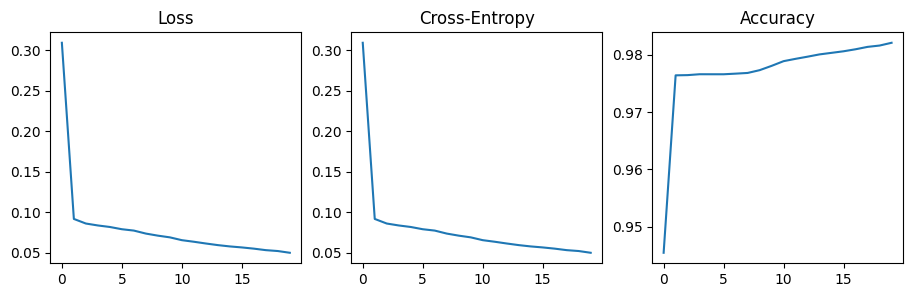

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Class 0 logit range - -4.176061153411865, 21.096250534057617
Class 1 logit range - -36.747596740722656, 3.2304561138153076


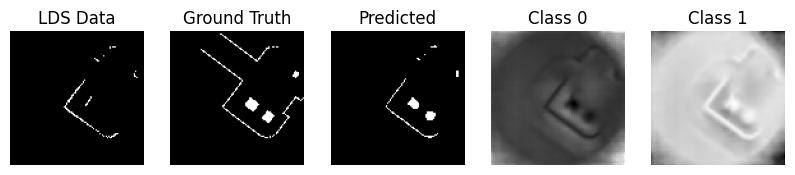

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Class 0 logit range - -7.0339155197143555, 28.419424057006836
Class 1 logit range - -50.279266357421875, 4.424930095672607


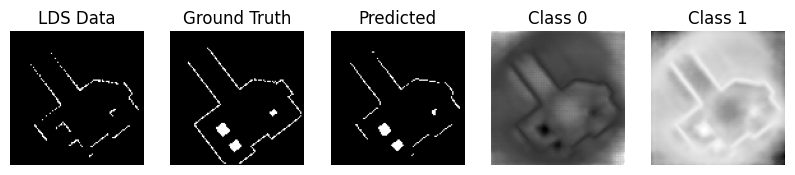

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Class 0 logit range - -4.669600009918213, 16.806394577026367
Class 1 logit range - -30.507736206054688, 3.5135622024536133


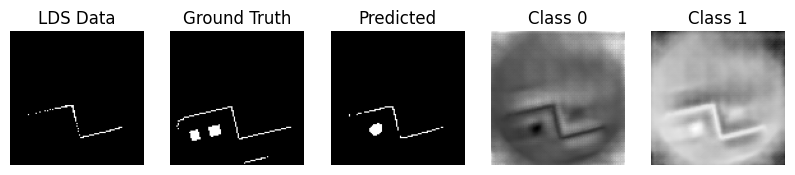

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Class 0 logit range - -2.270082712173462, 22.850217819213867
Class 1 logit range - -38.39970016479492, 1.773512840270996


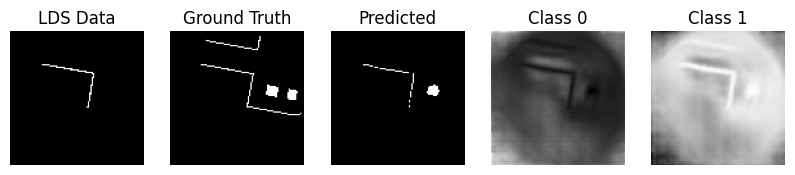

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Class 0 logit range - -1.7515889406204224, 19.49437141418457
Class 1 logit range - -35.51792526245117, 1.4486998319625854


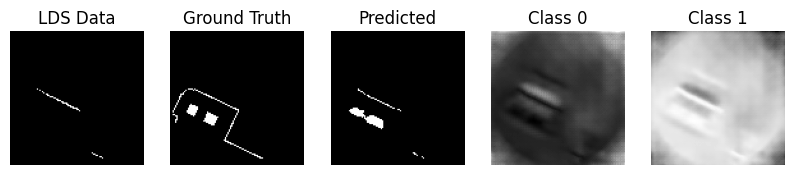

In [84]:
display_history(model_history)
show_predictions(model, dataset, 5)

## Blurred Loss Function
This uses a custom loss function based on blurring both the ground truth and predicted outputs before comparing. That way it should produce a smoother loss function that encourages "almost correct" placement of walls.

In [11]:
sample_gt, sample_image = next(iter(dataset))
batch = np.expand_dims(sample_image, axis=0)
batch_pred = model.predict(batch)
sample_pred = batch_pred[0]
print(f"sample_image: {sample_image.shape}, sample_pred: {sample_pred.shape}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
sample_image: (105, 105), sample_pred: (105, 105, 2)


Handle different dimensions:
res: (84, 94)
res: (1, 84, 94)
res: (1, 84, 94, 2)

Do blurring
input: (84, 94, 2), res: (84, 94, 2)


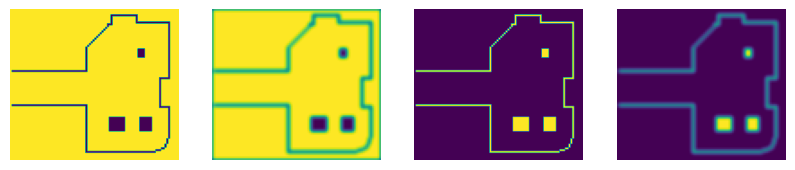

input: (84, 94, 2), res: (84, 94, 2)


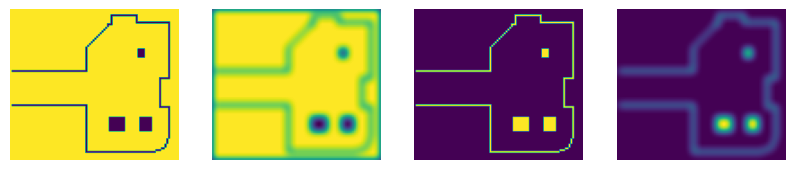

In [76]:
# From ChatGPT
# Define the blurring kernel, e.g., a 3x3 Gaussian kernel
def gaussian_blur(images, sigma=1.0, **kwargs):
    """
    Applies a Gaussian blur to the input images.

    Args:
      images: tensor of shape [batch_size, height, width, channels] or [batch_size, height, width] or [height, width]
      sigma: float, optional (default: 1.0). Standard deviation of the Gaussian kernel.

    Keyword args:
      kernel_size: int, size of the Gaussian kernel.
        Default: sufficient to cover 95% of the standard deviation.

    Returns:
      tensor of shape [batch_size, height, width, channels] or [batch_size, height, width] or [height, width]
    """

    # config
    default_kernel_size = 2 * np.ceil(2 * sigma) + 1
    kernel_size = kwargs.get("kernel_size", default_kernel_size)
    in_channels = images.shape[-1] if images.ndim > 3 else 1
    is_batch = images.ndim > 2

    #print(f"image: {images.shape}, kernel_size: {kernel_size}")

    # Reshape image with a batch and channel dimension if needed
    if not is_batch:
        images = tf.expand_dims(images, axis=0)
    if in_channels == 1:
        images = tf.expand_dims(images, axis=-1)
    #print(f"image: {images.shape}")

    x = tf.range(-kernel_size // 2 + 1, kernel_size // 2 + 1, dtype=tf.float32)
    gaussian_1d = tf.exp(-tf.square(x) / (2 * sigma ** 2))
    gaussian_1d /= tf.reduce_sum(gaussian_1d)

    # Build kernel with shape [filter_height, filter_width, in_channels, channel_multiplier=1]
    kernel = tf.tensordot(gaussian_1d, gaussian_1d, axes=0)
    #print(f"kernel: {kernel.shape}")
    kernel = kernel[:, :, tf.newaxis, tf.newaxis]
    #print(f"kernel: {kernel.shape}")
    kernel = tf.tile(kernel, [1, 1, in_channels, 1])  # Match input channels
    #print(f"kernel: {kernel.shape}")

    # Apply the kernel as a convolution against each channel separately
    blurred = tf.nn.depthwise_conv2d(images, kernel, strides=[1, 1, 1, 1], padding='SAME')

    # Remove extra dimensions if needed
    if not is_batch:
        blurred = tf.squeeze(blurred, axis=0)
    if in_channels == 1:
        blurred = tf.squeeze(blurred, axis=-1)

    return blurred

def gaussian_blur_test(image, sigma=1.0, **kwargs):
  sample = tf.expand_dims(image, axis=0)  # batch
  res = gaussian_blur(sample, sigma, **kwargs)[0]
  print(f"input: {image.shape}, res: {res.shape}")

  plt.figure(figsize=(10,15))
  plt.subplot(1,4,1)
  plt.imshow(image[:,:,0])
  plt.axis('off')

  plt.subplot(1,4,2)
  plt.imshow(res[:,:,0])
  plt.axis('off')

  plt.subplot(1,4,3)
  plt.imshow(image[:,:,1])
  plt.axis('off')

  plt.subplot(1,4,4)
  plt.imshow(res[:,:,1])
  plt.axis('off')

  plt.show()

print("Handle different dimensions:")
b = gaussian_blur(tf.cast(floorplan, tf.float32))
print(f"res: {b.shape}")
b = gaussian_blur(tf.expand_dims(tf.cast(floorplan, tf.float32), axis=0))
print(f"res: {b.shape}")
b = gaussian_blur(tf.expand_dims(tf.one_hot(tf.cast(floorplan, tf.uint8), 2), axis=0))
print(f"res: {b.shape}")

print()
print("Do blurring")
fp_pred = tf.one_hot(tf.cast(floorplan, tf.uint8), 2)
gaussian_blur_test(fp_pred, sigma=1.0)
gaussian_blur_test(fp_pred, sigma=2.0)


y_trues: (1, 105, 105) of type bool
y_preds1: (1, 105, 105, 2) of type <dtype: 'float32'> in range (-16.11809539794922 - 1.1920928244535389e-07), (-16.11809539794922 - 1.1920928244535389e-07)
y_preds2: (1, 105, 105, 2) of type <dtype: 'float32'> in range (-16.11809539794922 - 1.1920928244535389e-07), (-16.11809539794922 - 1.1920928244535389e-07)
y_preds3: (1, 105, 105, 2) of type <dtype: 'float32'> in range (-16.11809539794922 - 1.1920928244535389e-07), (-16.11809539794922 - 1.1920928244535389e-07)
loss1: simple=1.1920928244535389e-07, unblurred=1.1920930376163597e-07, blurred=0.055598415434360504
loss2: simple=0.43273985385894775, unblurred=0.4327399432659149, blurred=0.07406420260667801
loss3: simple=0.58770751953125, unblurred=0.5877075791358948, blurred=0.34834587574005127


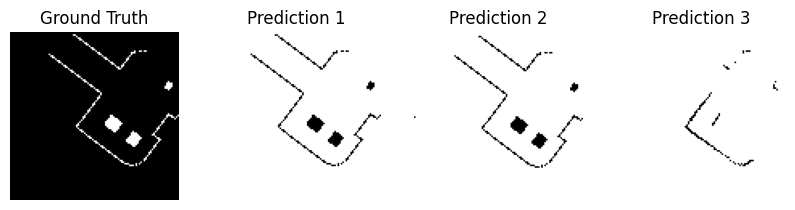

In [10]:
# Define the custom loss function with blurring
def blurred_multiclass_crossentropy(y_trues, y_preds):
    """
    Custom loss function that combines categorical cross-entropy and Gaussian blur.

    Args:
      y_trues: categorical encoded tensor of shape [batch_size, height, width], of type bool or int
      y_preds: tensor of shape [batch_size, height, width, num_classes], containing logits of type float

    Returns:
      tensor of shape [batch_size] containing losses
    """

    # convert y_trues from categorical into one-hot encoding
    y_trues = tf.one_hot(tf.cast(y_trues, tf.uint8), y_preds.shape[-1])

    # convert y_preds from logits into preds
    # (need a uniform value space for the blurring to work correctly, so can't keep in logits)
    y_preds = tf.nn.softmax(y_preds)

    # Apply Gaussian blur to both ground truth and predictions
    y_trues_blurred = gaussian_blur(y_trues, 1.0)
    y_preds_blurred = gaussian_blur(y_preds, 1.0)

    # Compute loss
    # (note: both y_trues and y_preds are now in probs units)
    return tf.keras.losses.categorical_crossentropy(y_trues_blurred, y_preds_blurred)

def normal_crossentry_loss(y_trues, y_preds):
    # convert y_trues from categorical into one-hot encoding
    y_trues = tf.one_hot(tf.cast(y_trues, tf.uint8), y_preds.shape[-1])

    # convert y_preds from logits into preds
    # (need a uniform value space for the blurring to work correctly, so can't keep in logits)
    y_preds = tf.nn.softmax(y_preds)

    # Compute loss
    # (note: both y_trues and y_preds are now in probs units)
    return tf.keras.losses.categorical_crossentropy(y_trues, y_preds)


def blurred_multiclass_crossentropy_test():
  lds, gt = next(iter(dataset))
  y_trues = np.expand_dims(gt, axis=0)
  y_preds1 = tf.one_hot(tf.cast(y_trues, tf.uint8), 2)
  y_preds1 = tf.math.log(y_preds1 + 1e-7) # softmax to logits
  y_preds2 = tf.roll(y_preds1, shift=(1, 1), axis=(1, 2)) # same as y_preds1 but shifted by 1x1
  y_preds3 = tf.one_hot(tf.cast(np.expand_dims(lds, axis=0), tf.uint8), 2)
  y_preds3 = tf.math.log(y_preds3 + 1e-7) # softmax to logits

  # Experiments:
  #  - loss1 - exactly identical inputs
  #  - loss2 - exactly identical but shifted by 1 px
  #  - loss3 - ground truth vs LDS
  # Values:
  #  - simple - baseline to check that we're getting sensible values
  #  - normal - manual loss computation without blurring, should be the same as simple if I've got the logic correct
  #  - blurred - same code as for normal, but with blurring added
  # Expected outcome:
  #  - When unblurred, we'll see that shifted by 1 px vs raw LDS data will both be treated as high loss
  #  - When blurred,   shifted by 1px should have low loss, while raw LDS should still have a high loss
  #  - When blurred,   exact will have non-zero loss due the way the loss fn works, but it should still be significantly less then the others
  loss1s = tf.reduce_mean(tf.keras.losses.sparse_categorical_crossentropy(y_trues, y_preds1, from_logits=True))
  loss2s = tf.reduce_mean(tf.keras.losses.sparse_categorical_crossentropy(y_trues, y_preds2, from_logits=True))
  loss3s = tf.reduce_mean(tf.keras.losses.sparse_categorical_crossentropy(y_trues, y_preds3, from_logits=True))
  loss1n = tf.reduce_mean(normal_crossentry_loss(y_trues, y_preds1))
  loss2n = tf.reduce_mean(normal_crossentry_loss(y_trues, y_preds2))
  loss3n = tf.reduce_mean(normal_crossentry_loss(y_trues, y_preds3))
  loss1b = tf.reduce_mean(blurred_multiclass_crossentropy(y_trues, y_preds1))
  loss2b = tf.reduce_mean(blurred_multiclass_crossentropy(y_trues, y_preds2))
  loss3b = tf.reduce_mean(blurred_multiclass_crossentropy(y_trues, y_preds3))
  print(f"y_trues: {y_trues.shape} of type {y_trues.dtype}")
  print(f"y_preds1: {y_preds1.shape} of type {y_preds1.dtype} in range ({tf.reduce_min(y_preds1[...,0])} - {tf.reduce_max(y_preds1[...,0])}), ({tf.reduce_min(y_preds1[...,1])} - {tf.reduce_max(y_preds1[...,1])})")
  print(f"y_preds2: {y_preds2.shape} of type {y_preds2.dtype} in range ({tf.reduce_min(y_preds2[...,0])} - {tf.reduce_max(y_preds2[...,0])}), ({tf.reduce_min(y_preds2[...,1])} - {tf.reduce_max(y_preds2[...,1])})")
  print(f"y_preds3: {y_preds3.shape} of type {y_preds3.dtype} in range ({tf.reduce_min(y_preds3[...,0])} - {tf.reduce_max(y_preds3[...,0])}), ({tf.reduce_min(y_preds3[...,1])} - {tf.reduce_max(y_preds3[...,1])})")
  print(f"loss1: simple={loss1s}, unblurred={loss1n}, blurred={loss1b}")
  print(f"loss2: simple={loss2s}, unblurred={loss2n}, blurred={loss2b}")
  print(f"loss3: simple={loss3s}, unblurred={loss3n}, blurred={loss3b}")

  plt.figure(figsize=(10,15))

  plt.subplot(1,4,1)
  plt.title('Ground Truth')
  plt.axis('off')
  plt.imshow(y_trues[0], cmap='gray')

  plt.subplot(1,4,2)
  plt.title('Prediction 1')
  plt.axis('off')
  plt.imshow(y_preds1[0,:,:,0], cmap='gray')

  plt.subplot(1,4,3)
  plt.title('Prediction 2')
  plt.axis('off')
  plt.imshow(y_preds2[0,:,:,0], cmap='gray')

  plt.subplot(1,4,4)
  plt.title('Prediction 3')
  plt.imshow(y_preds3[0,:,:,0], cmap='gray')
  plt.axis('off')

  plt.show()

blurred_multiclass_crossentropy_test()

In [114]:
data_shape = next(iter(dataset))[0].shape
input_size = (data_shape[0], data_shape[1], 1)
n_filters=32
n_classes=2

model = unet.unet_model(input_size, n_filters, n_classes)
model.compile(optimizer='adam',
              #loss=blurred_multiclass_crossentropy,
              loss=normal_crossentry_loss,
              metrics=['accuracy', tf.keras.metrics.SparseCategoricalCrossentropy('ce', from_logits=True)])
epochs = 10
batch_size = 32
train_dataset = dataset.shuffle(buffer_size=len(X)).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

start = timer()
model_history = model.fit(train_dataset, epochs=epochs)
duration = (timer() - start)
print(f"Epochs: {epochs}, duration: {duration} sec")

Input size: (105, 105, 1)
Added padding layer: w=7, h=7
Skip-connection merge mode: concat
Added final cropping layer: w=7, h=7
Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 24s 324ms/step - accuracy: 0.8957 - ce: 0.5736 - loss: 0.5736
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - accuracy: 0.9762 - ce: 0.0916 - loss: 0.0916
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 135ms/step - accuracy: 0.9767 - ce: 0.0882 - loss: 0.0882
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 137ms/step - accuracy: 0.9764 - ce: 0.0889 - loss: 0.0889
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 137ms/step - accuracy: 0.9767 - ce: 0.0871 - loss: 0.0871
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 139ms/step - accuracy: 0.9768 - ce: 0.0864 - loss: 0.0864
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 138ms/step - accuracy: 0.9767 - ce: 0.0850 - loss: 0.0850
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 139ms/step - accuracy: 0.9767 - ce: 0.0850 - loss: 0.0850
Epoch 9/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 153ms/step - accuracy: 0.9765 - ce: 0.

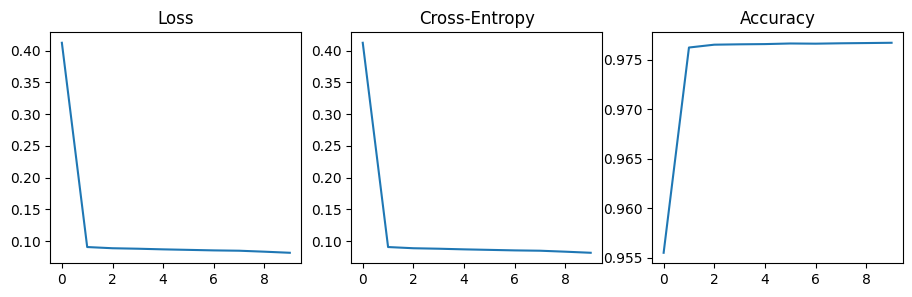

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 795ms/step
Class 0 logit range - -0.960191011428833, 3.7129626274108887
Class 1 logit range - -8.644783020019531, 0.27573201060295105


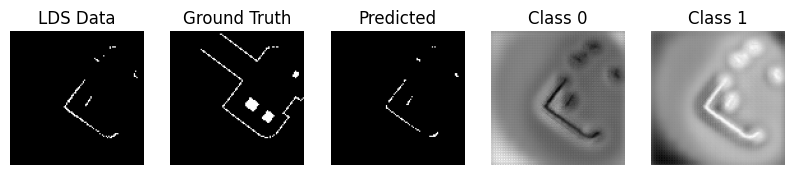

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Class 0 logit range - -0.8563050031661987, 3.468794822692871
Class 1 logit range - -8.249688148498535, 0.3429549038410187


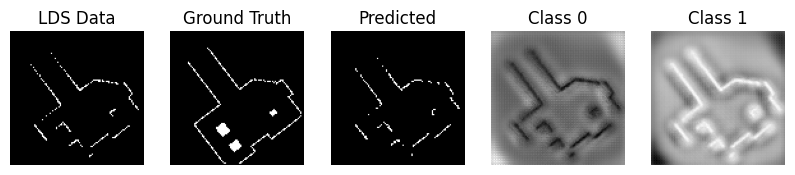

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Class 0 logit range - -0.7914965152740479, 3.3257086277008057
Class 1 logit range - -7.952580451965332, 0.4528621733188629


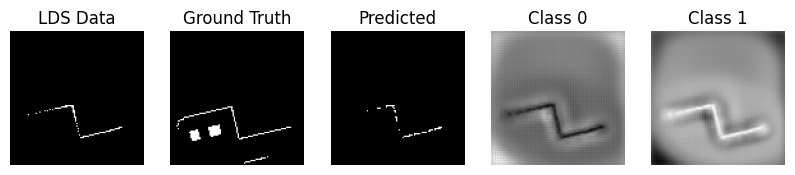

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Class 0 logit range - -0.7845353484153748, 3.3657779693603516
Class 1 logit range - -7.923491477966309, 0.4437377452850342


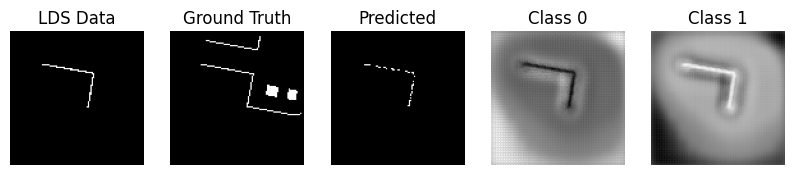

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Class 0 logit range - -0.48643457889556885, 3.535029888153076
Class 1 logit range - -8.191851615905762, 0.2483092099428177


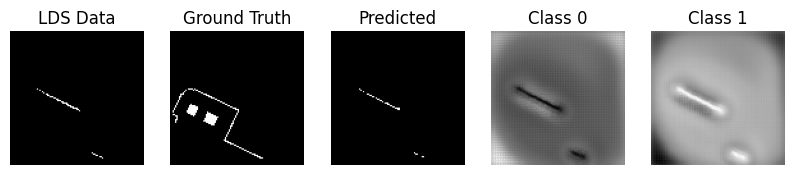

In [115]:
display_history(model_history)
show_predictions(model, dataset, 5)

## Blurred MSE Loss
Let's also try a blurred MSE loss function.

y_trues: (1, 105, 105) of type bool
y_preds1: (1, 105, 105, 2) of type <dtype: 'float32'> in range (-16.11809539794922 - 1.1920928244535389e-07), (-16.11809539794922 - 1.1920928244535389e-07)
y_preds2: (1, 105, 105, 2) of type <dtype: 'float32'> in range (-16.11809539794922 - 1.1920928244535389e-07), (-16.11809539794922 - 1.1920928244535389e-07)
y_preds3: (1, 105, 105, 2) of type <dtype: 'float32'> in range (-16.11809539794922 - 1.1920928244535389e-07), (-16.11809539794922 - 1.1920928244535389e-07)
loss1: unblurred=1.2105428963925247e-14, blurred=1.9026497906490455e-14
loss2: unblurred=0.026848066598176956, blurred=0.003514425829052925
loss3: unblurred=0.03646257519721985, blurred=0.01265142485499382


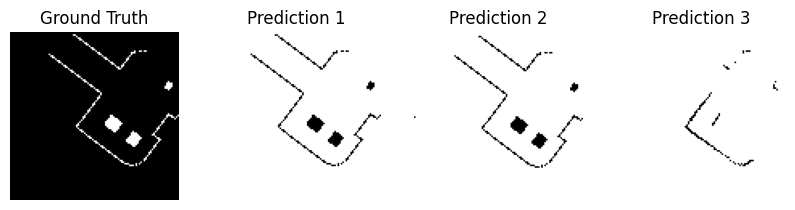

In [13]:
# Also define a custom MSE loss function with blurring
def blurred_multiclass_mse(y_trues, y_preds):
    """
    Custom loss function that combines MSE and Gaussian blur.

    Args:
      y_trues: categorical encoded tensor of shape [batch_size, height, width], of type bool or int
      y_preds: tensor of shape [batch_size, height, width, num_classes], containing logits of type float

    Returns:
      tensor of shape [batch_size] containing losses
    """

    # convert y_trues from categorical into one-hot encoding
    y_trues = tf.one_hot(tf.cast(y_trues, tf.uint8), y_preds.shape[-1])

    # convert y_preds from logits into preds
    # (need a uniform value space for the blurring to work correctly, so can't keep in logits)
    y_preds = tf.nn.softmax(y_preds)

    # Apply Gaussian blur to both ground truth and predictions
    y_trues_blurred = gaussian_blur(y_trues, 1.0)
    y_preds_blurred = gaussian_blur(y_preds, 1.0)

    # Compute loss
    # (note: both y_trues and y_preds are now in probs units)
    return tf.keras.losses.MSE(y_trues_blurred, y_preds_blurred)

def normal_mse_loss(y_trues, y_preds):
    # convert y_trues from categorical into one-hot encoding
    y_trues = tf.one_hot(tf.cast(y_trues, tf.uint8), y_preds.shape[-1])

    # convert y_preds from logits into preds
    # (need a uniform value space for the blurring to work correctly, so can't keep in logits)
    y_preds = tf.nn.softmax(y_preds)

    # Compute loss
    # (note: both y_trues and y_preds are now in probs units)
    return tf.keras.losses.MSE(y_trues, y_preds)


def blurred_multiclass_mse_test():
  lds, gt = next(iter(dataset))
  y_trues = np.expand_dims(gt, axis=0)
  y_preds1 = tf.one_hot(tf.cast(y_trues, tf.uint8), 2)
  y_preds1 = tf.math.log(y_preds1 + 1e-7) # softmax to logits
  y_preds2 = tf.roll(y_preds1, shift=(1, 1), axis=(1, 2)) # same as y_preds1 but shifted by 1x1
  y_preds3 = tf.one_hot(tf.cast(np.expand_dims(lds, axis=0), tf.uint8), 2)
  y_preds3 = tf.math.log(y_preds3 + 1e-7) # softmax to logits

  # Experiments:
  #  - loss1 - exactly identical inputs
  #  - loss2 - exactly identical but shifted by 1 px
  #  - loss3 - ground truth vs LDS
  # Values:
  #  - normal - manual loss computation without blurring, should be the same as simple if I've got the logic correct
  #  - blurred - same code as for normal, but with blurring added
  # Expected outcome:
  #  - When unblurred, we'll see that shifted by 1 px vs raw LDS data will both be treated as high loss
  #  - When blurred,   shifted by 1px should have low loss, while raw LDS should still have a high loss
  #  - When blurred,   exact will have non-zero loss due the way the loss fn works, but it should still be significantly less then the others
  loss1n = tf.reduce_mean(normal_mse_loss(y_trues, y_preds1))
  loss2n = tf.reduce_mean(normal_mse_loss(y_trues, y_preds2))
  loss3n = tf.reduce_mean(normal_mse_loss(y_trues, y_preds3))
  loss1b = tf.reduce_mean(blurred_multiclass_mse(y_trues, y_preds1))
  loss2b = tf.reduce_mean(blurred_multiclass_mse(y_trues, y_preds2))
  loss3b = tf.reduce_mean(blurred_multiclass_mse(y_trues, y_preds3))
  print(f"y_trues: {y_trues.shape} of type {y_trues.dtype}")
  print(f"y_preds1: {y_preds1.shape} of type {y_preds1.dtype} in range ({tf.reduce_min(y_preds1[...,0])} - {tf.reduce_max(y_preds1[...,0])}), ({tf.reduce_min(y_preds1[...,1])} - {tf.reduce_max(y_preds1[...,1])})")
  print(f"y_preds2: {y_preds2.shape} of type {y_preds2.dtype} in range ({tf.reduce_min(y_preds2[...,0])} - {tf.reduce_max(y_preds2[...,0])}), ({tf.reduce_min(y_preds2[...,1])} - {tf.reduce_max(y_preds2[...,1])})")
  print(f"y_preds3: {y_preds3.shape} of type {y_preds3.dtype} in range ({tf.reduce_min(y_preds3[...,0])} - {tf.reduce_max(y_preds3[...,0])}), ({tf.reduce_min(y_preds3[...,1])} - {tf.reduce_max(y_preds3[...,1])})")
  print(f"loss1: unblurred={loss1n}, blurred={loss1b}")
  print(f"loss2: unblurred={loss2n}, blurred={loss2b}")
  print(f"loss3: unblurred={loss3n}, blurred={loss3b}")

  plt.figure(figsize=(10,15))

  plt.subplot(1,4,1)
  plt.title('Ground Truth')
  plt.axis('off')
  plt.imshow(y_trues[0], cmap='gray')

  plt.subplot(1,4,2)
  plt.title('Prediction 1')
  plt.axis('off')
  plt.imshow(y_preds1[0,:,:,0], cmap='gray')

  plt.subplot(1,4,3)
  plt.title('Prediction 2')
  plt.axis('off')
  plt.imshow(y_preds2[0,:,:,0], cmap='gray')

  plt.subplot(1,4,4)
  plt.title('Prediction 3')
  plt.imshow(y_preds3[0,:,:,0], cmap='gray')
  plt.axis('off')

  plt.show()

blurred_multiclass_mse_test()

In [30]:
# Let's sanity check what kind of output we should be generating from our loss functions
# Result: a scalar tensor.
loss_fn = tf.keras.metrics.SparseCategoricalCrossentropy('ce', from_logits=True)
a = tf.ones(shape=(10, 100, 100))
b = tf.ones(shape=(10, 100, 100, 2))
print(f"TF loss: {loss_fn(a, b)}")

def local_loss(y_trues, y_preds):
    batch_size = tf.cast(tf.shape(y_preds)[0], tf.float32)
    y_preds = tf.nn.softmax(y_preds)
    losses = tf.keras.losses.sparse_categorical_crossentropy(y_trues, y_preds)

    # works but it's about 10000x bigger than normal ce
    #return tf.reduce_sum(losses) / batch_size

    # gets same values as tf.keras.metrics.SparseCategoricalCrossentropy()
    tf.print(f"loss: {tf.shape(losses)}")
    return tf.reduce_mean(losses)
print(f"My loss: {local_loss(a, b)}")


TF loss: 0.6931474804878235
loss: [ 10 100 100]
My loss: 0.6931471824645996


## Trying various loss functions

Input size: (105, 105, 1)
Added padding layer: w=7, h=7
Skip-connection merge mode: concat
Added final cropping layer: w=7, h=7
Epoch 1/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 23s 341ms/step - accuracy: 0.9297 - blurred_multiclass_mse: 0.0508 - ce: 2940164.7500 - loss: 0.3991 - mse: 0.0710 - scce: 3032455.7500
Epoch 2/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.9762 - blurred_multiclass_mse: 0.0104 - ce: 101997960.0000 - loss: 0.3831 - mse: 0.0238 - scce: 102025352.0000
Epoch 3/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - accuracy: 0.9757 - blurred_multiclass_mse: 0.0106 - ce: 160674704.0000 - loss: 0.3910 - mse: 0.0243 - scce: 160706288.0000
Epoch 4/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 135ms/step - accuracy: 0.9767 - blurred_multiclass_mse: 0.0102 - ce: 154829008.0000 - loss: 0.3757 - mse: 0.0233 - scce: 154843440.0000
Epoch 5/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - accuracy: 0.9763 - blurred_multiclass_mse: 0.0104 - ce: 157819472.0000 - loss: 0.3822 - mse: 0.0237 - scce: 15779

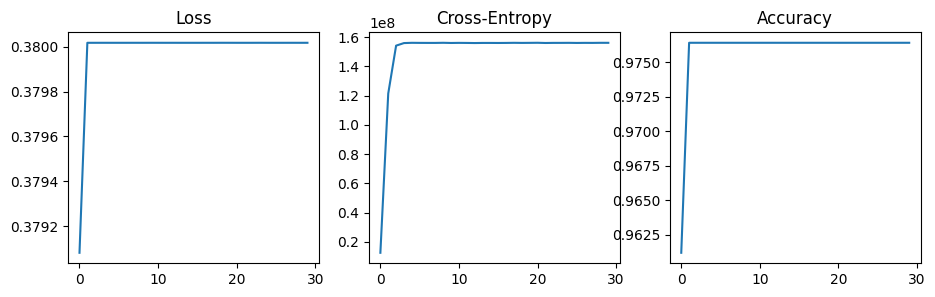

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 581ms/step
Class 0 logit range - 6509557.5, 3614992896.0
Class 1 logit range - -5757636608.0, -36943564.0


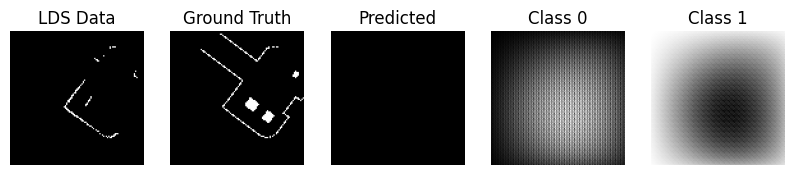

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Class 0 logit range - 20185414.0, 4811585024.0
Class 1 logit range - -7665160192.0, -114038664.0


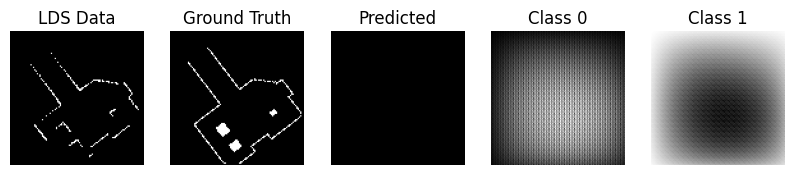

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Class 0 logit range - 4624660.0, 2954809856.0
Class 1 logit range - -4735837696.0, -26267612.0


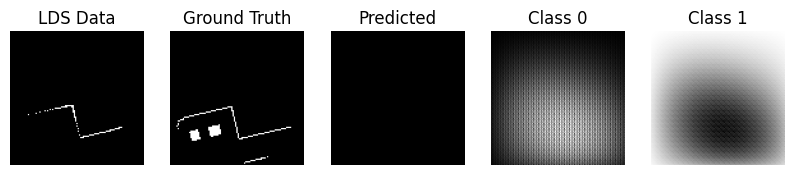

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Class 0 logit range - 15420920.0, 2744487680.0
Class 1 logit range - -4390021120.0, -47235496.0


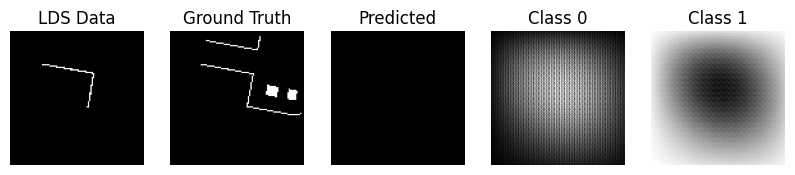

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Class 0 logit range - 7575900.5, 2149408768.0
Class 1 logit range - -3407302656.0, -42903440.0


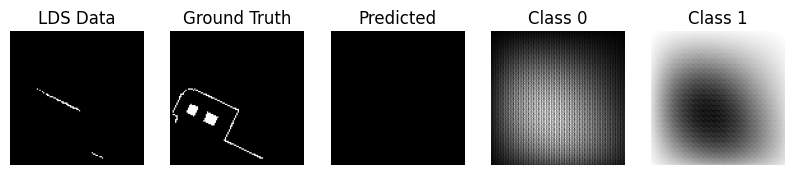

In [82]:
# works, approximates SparseCategoricalCrossentropy(from_logits=True)
def scce(y_trues, y_preds):
    y_preds = tf.nn.softmax(y_preds)
    losses = tf.keras.losses.sparse_categorical_crossentropy(y_trues, y_preds)
    return tf.reduce_mean(losses)

# works, approximates SparseCategoricalCrossentropy(from_logits=True)
def cce(y_trues, y_preds):
    y_trues = tf.one_hot(tf.cast(y_trues, tf.uint8), y_preds.shape[-1])
    y_preds = tf.nn.softmax(y_preds)
    losses = tf.keras.losses.categorical_crossentropy(y_trues, y_preds)
    return tf.reduce_mean(losses)

# doesn't work
def blurred_cce(y_trues, y_preds):
    y_trues = tf.one_hot(tf.cast(y_trues, tf.uint8), y_preds.shape[-1])
    y_preds = tf.nn.softmax(y_preds)
    y_trues_blurred = gaussian_blur(y_trues, 1.0)
    y_preds_blurred = gaussian_blur(y_preds, 1.0)
    losses = tf.keras.losses.categorical_crossentropy(y_trues_blurred, y_preds_blurred)
    return tf.reduce_mean(losses)

# works when running against images, but not during NN training
def mse(y_trues, y_preds):
    # replicate MeanSquaredError, assuming we add a softmax layer at the end of the model (which we don't)
    channels = tf.shape(y_preds)[-1]
    y_trues = tf.one_hot(tf.cast(y_trues, tf.uint8), channels)  # res: [N,H,W,C] float32
    y_preds = tf.nn.softmax(y_preds)
    losses = tf.keras.losses.MSE(y_trues, y_preds)
    return tf.reduce_mean(losses)

def local_loss(y_trues, y_preds):
  #return scce(y_trues, y_preds)
  return mse(y_trues, y_preds)


# Run the model with the blurred cross-entropy loss
data_shape = next(iter(dataset))[0].shape
input_size = (data_shape[0], data_shape[1], 1)
n_filters=32
n_classes=2

tf.config.run_functions_eagerly(False)
model = unet.unet_model(input_size, n_filters, n_classes)
model.compile(optimizer='adam',
              #loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              loss = blurred_cce,
              metrics=[
                    'accuracy',
                    blurred_multiclass_mse,
                    tf.keras.metrics.SparseCategoricalCrossentropy('ce', from_logits=True),
                    mse,
                    scce
              ])
epochs = 30
batch_size = 32
train_dataset = dataset.shuffle(buffer_size=len(X)).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

start = timer()
model_history = model.fit(train_dataset, epochs=epochs)
duration = (timer() - start)
print(f"Epochs: {epochs}, duration: {duration} sec")
display_history(model_history)
show_predictions(model, dataset, 5)

## Finally - An actually working version
It turns out that the blurred_cce loss function is unstable. It leads to finding a local minima in the shape of a repeating grid pattern.

But if I initialise with normal scce initially, I can then get past the local minima.

Input size: (105, 105, 1)
Added padding layer: w=7, h=7
Skip-connection merge mode: concat
Added final cropping layer: w=7, h=7
Epoch 1/2
32/32 ━━━━━━━━━━━━━━━━━━━━ 24s 349ms/step - accuracy: 0.9505 - blurred_multiclass_mse: 0.1321 - ce: 0.5525 - loss: 0.5525 - mse: 0.1495 - scce: 0.5521
Epoch 2/2
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 142ms/step - accuracy: 0.9769 - blurred_multiclass_mse: 0.0094 - ce: 0.1092 - loss: 0.1092 - mse: 0.0223 - scce: 0.1091
Epochs: 2, duration: 32.27812833700227 sec
Epoch 1/18
32/32 ━━━━━━━━━━━━━━━━━━━━ 22s 322ms/step - accuracy: 0.9763 - blurred_multiclass_mse: 0.0092 - ce: 0.1057 - loss: 0.1073 - mse: 0.0217 - scce: 0.1057
Epoch 2/18
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 141ms/step - accuracy: 0.9763 - blurred_multiclass_mse: 0.0075 - ce: 0.0899 - loss: 0.0919 - mse: 0.0199 - scce: 0.0898
Epoch 3/18
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 143ms/step - accuracy: 0.9764 - blurred_multiclass_mse: 0.0074 - ce: 0.0869 - loss: 0.0891 - mse: 0.0197 - scce: 0.0869
Epoch 4/18
32/32 ━━━━━━━

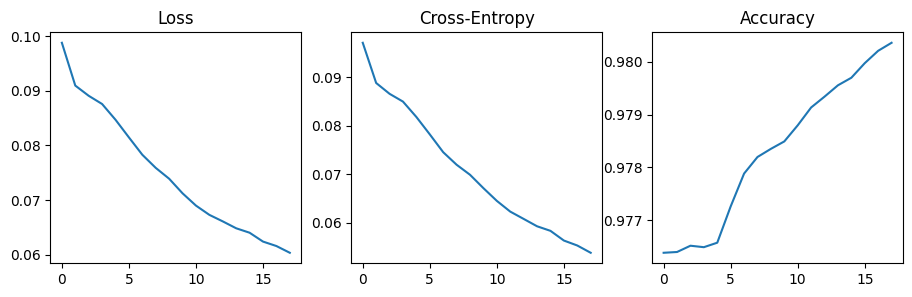

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 578ms/step
Class 0 logit range - -10.720112800598145, 9.087196350097656
Class 1 logit range - -37.46847152709961, 11.23006534576416


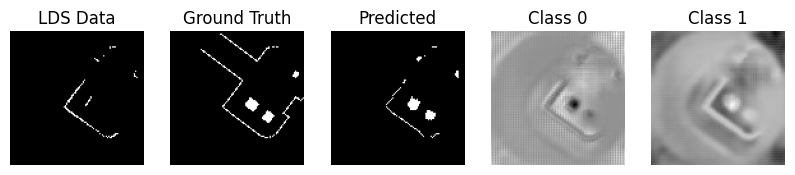

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Class 0 logit range - -13.387862205505371, 13.262205123901367
Class 1 logit range - -52.247398376464844, 11.916265487670898


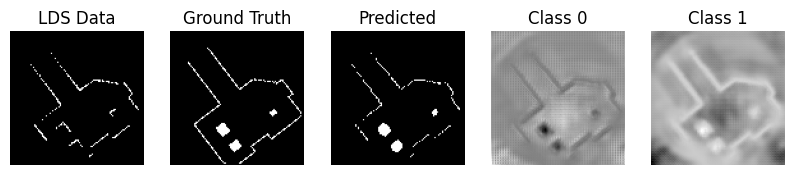

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Class 0 logit range - -5.3405609130859375, 9.01691722869873
Class 1 logit range - -32.43441390991211, 5.212384223937988


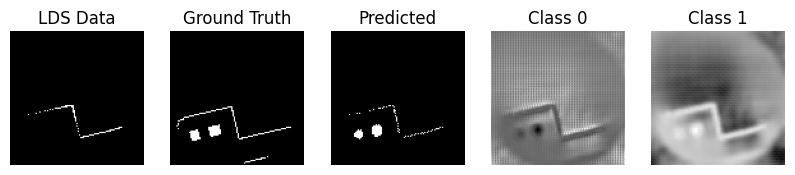

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Class 0 logit range - -1.4114792346954346, 6.644357204437256
Class 1 logit range - -28.95538330078125, 0.9461815357208252


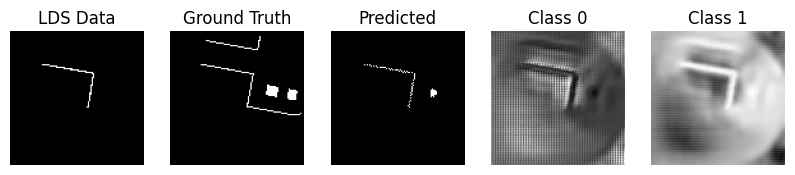

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Class 0 logit range - -2.3674638271331787, 9.93062686920166
Class 1 logit range - -42.323524475097656, 2.1406948566436768


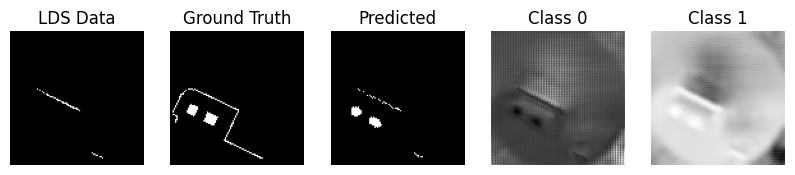

In [79]:
def blurred_cce(y_trues, y_preds):
    y_trues = tf.one_hot(tf.cast(y_trues, tf.uint8), y_preds.shape[-1])
    y_preds = tf.nn.softmax(y_preds)
    y_trues_blurred = gaussian_blur(y_trues, 1.0)
    y_preds_blurred = gaussian_blur(y_preds, 1.0)
    losses = tf.keras.losses.categorical_crossentropy(y_trues_blurred, y_preds_blurred)
    return tf.reduce_mean(losses)

# First phase - scce
data_shape = next(iter(dataset))[0].shape
input_size = (data_shape[0], data_shape[1], 1)
n_filters=32
n_classes=2

tf.config.run_functions_eagerly(False)
model = unet.unet_model(input_size, n_filters, n_classes)
model.compile(optimizer='adam',
              #loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              loss = scce,
              metrics=[
                    'accuracy',
                    blurred_multiclass_mse,
                    tf.keras.metrics.SparseCategoricalCrossentropy('ce', from_logits=True),
                    mse,
                    scce
              ])
epochs = 2
batch_size = 32
train_dataset = dataset.shuffle(buffer_size=len(X)).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

start = timer()
model_history = model.fit(train_dataset, epochs=epochs)
duration = (timer() - start)
print(f"Epochs: {epochs}, duration: {duration} sec")

# second phase - fine tune
model.compile(optimizer='adam',
              #loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              loss = blurred_cce,
              metrics=[
                    'accuracy',
                    blurred_multiclass_mse,
                    tf.keras.metrics.SparseCategoricalCrossentropy('ce', from_logits=True),
                    mse,
                    scce
              ])
epochs = 18
batch_size = 32
train_dataset = dataset.shuffle(buffer_size=len(X)).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

start = timer()
model_history = model.fit(train_dataset, epochs=epochs)
duration = (timer() - start)
print(f"Epochs: {epochs}, duration: {duration} sec")
display_history(model_history)
show_predictions(model, dataset, 5)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
xs: (1, 105, 105), y_trues: (1, 105, 105), y_preds: (1, 105, 105, 2), losses: (1, 105, 105)
mse: 0.014404208399355412


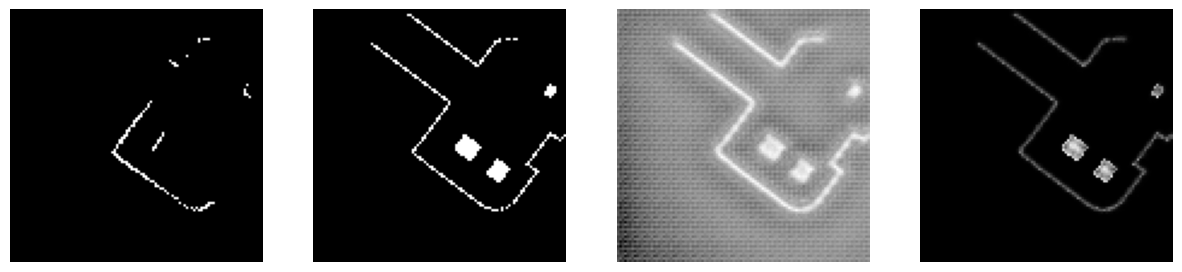

In [65]:
def mse(y_trues, y_preds):
    # replicate MeanSquaredError, assuming we add a softmax layer at the end of the model (which we don't)
    channels = tf.shape(y_preds)[-1]
    y_trues = tf.one_hot(tf.cast(y_trues, tf.uint8), channels)  # res: [N,H,W,C] float32
    y_preds = tf.nn.softmax(y_preds)
    losses = tf.keras.losses.MSE(y_trues, y_preds)
    return tf.reduce_mean(losses)

def mse2(y_trues, y_preds):
    # replicate MeanSquaredError, assuming we add a softmax layer at the end of the model (which we don't)
    channels = tf.shape(y_preds)[-1]
    y_trues = tf.one_hot(tf.cast(y_trues, tf.uint8), channels)  # res: [N,H,W,C] float32
    y_preds = tf.nn.softmax(y_preds)
    losses = tf.keras.losses.MSE(y_trues, y_preds)
    return losses;

lds, gt = next(iter(dataset))
xs = tf.expand_dims(lds, axis=0)
y_trues = tf.expand_dims(gt, axis=0)
y_preds = model.predict(y_trues)
losses = mse2(y_trues, y_preds)
print(f"xs: {xs.shape}, y_trues: {y_trues.shape}, y_preds: {y_preds.shape}, losses: {losses.shape}")
print(f"mse: {mse(y_trues, y_preds)}")

plt.figure(figsize=(15,5))
plt.subplot(1,4,1)
plt.imshow(xs[0,:,:], cmap='gray')
plt.axis('off')

plt.subplot(1,4,2)
plt.imshow(y_trues[0,:,:], cmap='gray')
plt.axis('off')

plt.subplot(1,4,3)
plt.imshow(y_preds[0,:,:,1], cmap='gray')
plt.axis('off')

plt.subplot(1,4,4)
plt.imshow(losses[0,:,:], cmap='gray')
plt.axis('off')
plt.show()


y_true: (1, 105, 105) of <dtype: 'bool'>
y_pred: (1, 105, 105, 2) of <dtype: 'float32'>
Step 0: Loss = 0.07957237958908081
Step 100: Loss = 0.05596484988927841
Step 200: Loss = 0.055757295340299606
Step 300: Loss = 0.055691689252853394
Step 400: Loss = 0.05566145107150078
Step 500: Loss = 0.055644646286964417


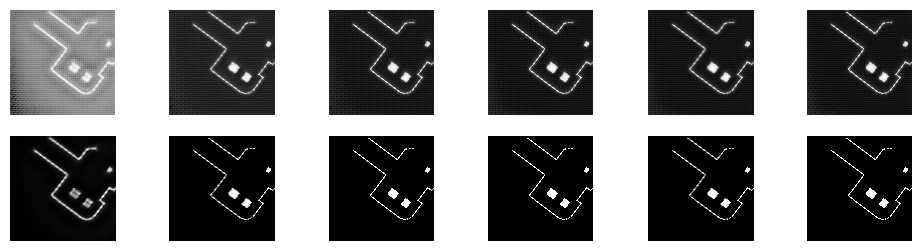

In [68]:
# doesn't work
def blurred_cce(y_trues, y_preds):
    y_trues = tf.one_hot(tf.cast(y_trues, tf.uint8), y_preds.shape[-1])
    y_preds = tf.nn.softmax(y_preds)
    y_trues_blurred = gaussian_blur(y_trues, 1.0)
    y_preds_blurred = gaussian_blur(y_preds, 1.0)
    losses = tf.keras.losses.categorical_crossentropy(y_trues_blurred, y_preds_blurred)
    return tf.reduce_mean(losses)

def training_step(y_true, y_pred, loss_fn):
    with tf.GradientTape() as tape:
        loss = loss_fn(y_true, y_pred)
    gradients = tape.gradient(loss, [y_pred])
    optimizer.apply_gradients(zip(gradients, [y_pred]))
    return loss

#loss_fn = mse
loss_fn = blurred_cce
train_y_trues = y_trues
train_y_preds = tf.Variable(y_preds)
optimizer = tf.optimizers.Adam(learning_rate=0.1)

print(f"y_true: {train_y_trues.shape} of {train_y_trues.dtype}")
print(f"y_pred: {train_y_preds.shape} of {train_y_preds.dtype}")
plt.figure(figsize=(12,3))
for step in range(501):
  loss = training_step(train_y_trues, train_y_preds, loss_fn)
  if step % 100 == 0:
    sm = tf.nn.softmax(train_y_preds, axis=-1)
    print(f"Step {step}: Loss = {loss}")
    plt.subplot(2,6,1 + step // 100)
    plt.imshow(train_y_preds[0,:,:,1], cmap='gray')
    plt.axis('off')
    plt.subplot(2,6,7 + step // 100)
    plt.imshow(sm[0,:,:,1], cmap='gray')
    plt.axis('off')

plt.show()

## Further investigation
Something's not working as expected.

y_trues: (1, 105, 105, 2) in range (0.0 - 1.0)
y_preds: (1, 105, 105, 2) in range (0.0 - 1.0)
loss(gt,gt): (1, 105, 105) in range (1.1920930376163597e-07 - 1.1920930376163597e-07)

y_trues: (1, 105, 105, 2) in range (0.0 - 1.0)
y_preds: (1, 105, 105, 2) in range (-16.11809539794922 - 1.1920928244535389e-07)
loss(gt,logit(gt)): (1, 105, 105) in range (1.1920928244535389e-07 - 1.1920928244535389e-07)

y_trues: (1, 105, 105, 2) in range (-16.11809539794922 - 1.1920928244535389e-07)
y_preds: (1, 105, 105, 2) in range (-16.11809539794922 - 1.1920928244535389e-07)
loss(logit(gt),logit(gt)): (1, 105, 105) in range (-259.7929992675781 - -259.7929992675781)

y_trues: (1, 105, 105, 2) in range (0.0 - 1.0)
y_preds: (1, 105, 105, 2) in range (0.0 - 1.0)
loss(gt,gt+1x1): (1, 105, 105) in range (1.1920930376163597e-07 - 16.11809539794922)


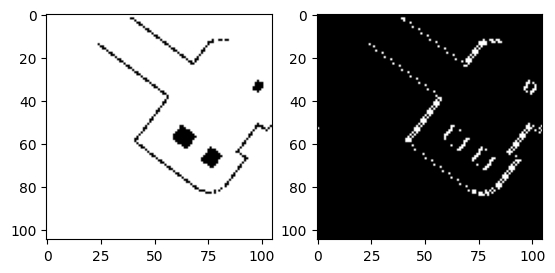

y_trues: (1, 105, 105, 2) in range (0.0 - 1.0000001192092896)
y_preds: (1, 105, 105, 2) in range (0.0 - 1.0000001192092896)
loss(gt,gt): (1, 105, 105) in range (5.863139307393794e-08 - 0.6930942535400391)


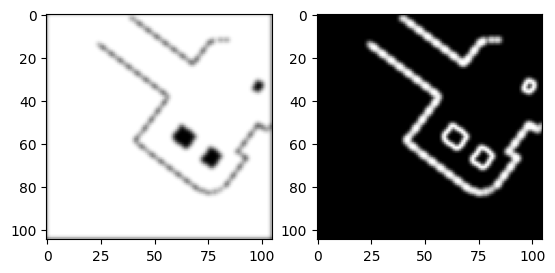

y_trues: (1, 105, 105, 2) in range (0.0 - 1.0000001192092896)
y_preds: (1, 105, 105, 2) in range (0.0 - 1.0000001192092896)
loss(gt,gt+1x1): (1, 105, 105) in range (5.863139307393794e-08 - 1.7992075681686401)


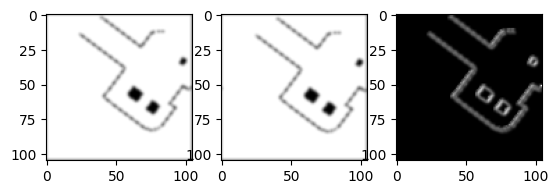

y_trues: (1, 105, 105, 2) in range (0.0 - 1.0000001192092896)
y_preds: (1, 105, 105, 2) in range (0.0 - 1.0000001192092896)
loss(gt,gt+lots): (1, 105, 105) in range (5.863139307393794e-08 - 16.11809730529785)


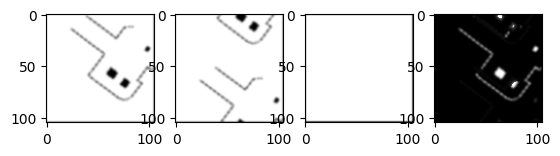

In [55]:
def cross_entropy_experiments():
  # create a true and pred as exact copies (result: works)
  lds, gt = next(iter(dataset))
  y_trues = tf.one_hot(tf.cast(np.expand_dims(gt, axis=0), tf.uint8), 2)
  y_preds = y_trues

  print(f"y_trues: {y_trues.shape} in range ({tf.reduce_min(y_trues)} - {tf.reduce_max(y_trues)})")
  print(f"y_preds: {y_preds.shape} in range ({tf.reduce_min(y_preds)} - {tf.reduce_max(y_preds)})")
  loss = tf.keras.losses.categorical_crossentropy(y_trues, y_preds)
  print(f"loss(gt,gt): {loss.shape} in range ({tf.reduce_min(loss)} - {tf.reduce_max(loss)})")

  # same again, but the y_preds is represented as logits (result: works)
  print()
  y_trues = tf.one_hot(tf.cast(np.expand_dims(gt, axis=0), tf.uint8), 2)
  y_preds = tf.math.log(y_trues + 1e-7) # softmax to logits
  print(f"y_trues: {y_trues.shape} in range ({tf.reduce_min(y_trues)} - {tf.reduce_max(y_trues)})")
  print(f"y_preds: {y_preds.shape} in range ({tf.reduce_min(y_preds)} - {tf.reduce_max(y_preds)})")
  loss = tf.keras.losses.categorical_crossentropy(y_trues, y_preds, from_logits=True)
  print(f"loss(gt,logit(gt)): {loss.shape} in range ({tf.reduce_min(loss)} - {tf.reduce_max(loss)})")

  # same again, but both are represented as logits (result: doesn't work)
  print()
  y_trues = tf.one_hot(tf.cast(np.expand_dims(gt, axis=0), tf.uint8), 2)
  y_trues = tf.math.log(y_trues + 1e-7) # softmax to logits
  y_preds = y_preds # softmax to logits
  print(f"y_trues: {y_trues.shape} in range ({tf.reduce_min(y_trues)} - {tf.reduce_max(y_trues)})")
  print(f"y_preds: {y_preds.shape} in range ({tf.reduce_min(y_preds)} - {tf.reduce_max(y_preds)})")
  loss = tf.keras.losses.categorical_crossentropy(y_trues, y_preds, from_logits=True)
  print(f"loss(logit(gt),logit(gt)): {loss.shape} in range ({tf.reduce_min(loss)} - {tf.reduce_max(loss)})")

  # pred is equal to true plus 1-pixel shift, compare w/o bluring
  print()
  y_trues = tf.one_hot(tf.cast(np.expand_dims(gt, axis=0), tf.uint8), 2)
  y_preds = tf.roll(y_trues, shift=(1, 1), axis=(1, 2))
  print(f"y_trues: {y_trues.shape} in range ({tf.reduce_min(y_trues)} - {tf.reduce_max(y_trues)})")
  print(f"y_preds: {y_preds.shape} in range ({tf.reduce_min(y_preds)} - {tf.reduce_max(y_preds)})")
  loss = tf.keras.losses.categorical_crossentropy(y_trues, y_preds)
  print(f"loss(gt,gt+1x1): {loss.shape} in range ({tf.reduce_min(loss)} - {tf.reduce_max(loss)})")
  plt.subplot(1,2,1)
  plt.imshow(y_trues[0,:,:,0], cmap='gray')
  plt.subplot(1,2,2)
  plt.imshow(loss[0,:,:], cmap='gray')
  plt.show()

  # true and pred as exact copies, both blurred
  y_trues = gaussian_blur(tf.one_hot(tf.cast(np.expand_dims(gt, axis=0), tf.uint8), 2))
  y_preds = y_trues
  print(f"y_trues: {y_trues.shape} in range ({tf.reduce_min(y_trues)} - {tf.reduce_max(y_trues)})")
  print(f"y_preds: {y_preds.shape} in range ({tf.reduce_min(y_preds)} - {tf.reduce_max(y_preds)})")
  loss = tf.keras.losses.categorical_crossentropy(y_trues, y_preds)
  print(f"loss(gt,gt): {loss.shape} in range ({tf.reduce_min(loss)} - {tf.reduce_max(loss)})")
  plt.subplot(1,2,1)
  plt.imshow(y_trues[0,:,:,0], cmap='gray')
  plt.subplot(1,2,2)
  plt.imshow(loss[0,:,:], cmap='gray')
  plt.show()

  # pred is equal to true plus 1-pixel shift, compare with bluring
  y_trues = tf.one_hot(tf.cast(np.expand_dims(gt, axis=0), tf.uint8), 2)
  y_preds = tf.roll(y_trues, shift=(1, 1), axis=(1, 2))
  y_trues = gaussian_blur(y_trues)
  y_preds = gaussian_blur(y_preds)
  print(f"y_trues: {y_trues.shape} in range ({tf.reduce_min(y_trues)} - {tf.reduce_max(y_trues)})")
  print(f"y_preds: {y_preds.shape} in range ({tf.reduce_min(y_preds)} - {tf.reduce_max(y_preds)})")
  loss = tf.keras.losses.categorical_crossentropy(y_trues, y_preds)
  print(f"loss(gt,gt+1x1): {loss.shape} in range ({tf.reduce_min(loss)} - {tf.reduce_max(loss)})")
  plt.subplot(1,3,1)
  plt.imshow(y_trues[0,:,:,0], cmap='gray')
  plt.subplot(1,3,2)
  plt.imshow(y_preds[0,:,:,0], cmap='gray')
  plt.subplot(1,3,3)
  plt.imshow(loss[0,:,:], cmap='gray')
  plt.show()

  # pred is equal to true plus a big shift, compare with bluring
  y_trues = tf.one_hot(tf.cast(np.expand_dims(gt, axis=0), tf.uint8), 2)
  y_preds = tf.roll(y_trues, shift=(50, 0), axis=(1, 2))
  y_trues = gaussian_blur(y_trues)
  y_preds = gaussian_blur(y_preds)
  print(f"y_trues: {y_trues.shape} in range ({tf.reduce_min(y_trues)} - {tf.reduce_max(y_trues)})")
  print(f"y_preds: {y_preds.shape} in range ({tf.reduce_min(y_preds)} - {tf.reduce_max(y_preds)})")
  loss = tf.keras.losses.categorical_crossentropy(y_trues, y_preds)
  print(f"loss(gt,gt+lots): {loss.shape} in range ({tf.reduce_min(loss)} - {tf.reduce_max(loss)})")
  plt.subplot(1,4,1)
  plt.imshow(y_trues[0,:,:,0], cmap='gray')
  plt.subplot(1,4,2)
  plt.imshow(y_preds[0,:,:,0], cmap='gray')
  plt.subplot(1,4,3)
  plt.imshow(tf.reduce_sum(y_trues,axis=-1)[0], cmap='gray')
  plt.subplot(1,4,4)
  plt.imshow(loss[0,:,:], cmap='gray')
  plt.show()

cross_entropy_experiments()

Perhaps the loss function doesn't do what I think.
To investigate, we can apply gradient descent against the output images directly. To see what output image minimises the loss function.

y_true: (1, 105, 105) of <dtype: 'bool'>
y_pred: (1, 105, 105, 2) of <dtype: 'float32'>
Step 0: Loss = 0.6991078853607178, ce = 0.9047777652740479, mse = 0.3193155527114868
Step 100: Loss = 0.05927896127104759, ce = 0.014161310158669949, mse = 0.002438037656247616
Step 200: Loss = 0.05727820843458176, ce = 0.006286764983087778, mse = 0.0007053534500300884
Step 300: Loss = 0.05658620595932007, ce = 0.00372782489284873, mse = 0.0002960598503705114
Step 400: Loss = 0.056261029094457626, ce = 0.002691752975806594, mse = 0.00018298494978807867
Step 500: Loss = 0.056078702211380005, ce = 0.002048798371106386, mse = 9.697632776806131e-05
Step 600: Loss = 0.05596500262618065, ce = 0.0016573927132412791, mse = 5.979837442282587e-05
Step 700: Loss = 0.055888693779706955, ce = 0.001394540653564036, mse = 4.216690649627708e-05
Step 800: Loss = 0.05583462864160538, ce = 0.0012030971702188253, mse = 3.1878138543106616e-05
Step 900: Loss = 0.055794741958379745, ce = 0.0010564790572971106, mse = 2.511

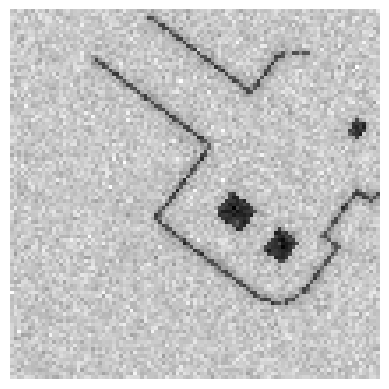

In [11]:
def normal_mse_loss(y_trues, y_preds):
    # convert y_trues from categorical into one-hot encoding
    y_trues = tf.one_hot(tf.cast(y_trues, tf.uint8), y_preds.shape[-1])

    # convert y_preds from logits into preds
    # (need a uniform value space for the blurring to work correctly, so can't keep in logits)
    y_preds = tf.nn.softmax(y_preds)

    # Compute loss
    # (note: both y_trues and y_preds are now in probs units)
    return tf.keras.losses.MSE(y_trues, y_preds)

def gd_against_pred():
  lds, gt = next(iter(dataset))
  #y_trues = tf.one_hot(tf.cast(np.expand_dims(gt, axis=0), tf.uint8), 2)
  y_true = tf.expand_dims(gt, axis=0)  # categorical representation
  y_pred = tf.Variable(tf.random.normal(shape=np.concatenate((y_true.shape, [2]))))
  optimizer = tf.optimizers.Adam(learning_rate=0.1)

  def compute_loss(y_true, y_pred):
    #return tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred, from_logits=True)

    #y_true = tf.one_hot(tf.cast(y_true, tf.uint8), 2)
    #y_pred = tf.nn.softmax(y_pred)
    #mse = tf.keras.losses.MSE(y_true, y_pred)
    #return mse

    #return normal_mse_loss(y_true, y_pred)

    #return blurred_multiclass_mse(y_true, y_pred)

    return blurred_multiclass_crossentropy(y_true, y_pred)

  def compute_metrics(y_true, y_pred):
    ce = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred, from_logits=True)

    y_true = tf.one_hot(tf.cast(y_true, tf.uint8), 2)
    y_pred = tf.nn.softmax(y_pred)
    mse = tf.keras.losses.MSE(y_true, y_pred)
    return ce, mse

  def training_step():
    with tf.GradientTape() as tape:
        loss = compute_loss(y_true, y_pred)
    metrics = compute_metrics(y_true, y_pred)
    # Compute gradients
    gradients = tape.gradient(loss, [y_pred])
    # Apply gradients to update y_pred
    optimizer.apply_gradients(zip(gradients, [y_pred]))
    return (loss,) + metrics

  print(f"y_true: {y_true.shape} of {y_true.dtype}")
  print(f"y_pred: {y_pred.shape} of {y_pred.dtype}")
  for step in range(1001):
    loss, ce, mse = training_step()
    if step % 100 == 0:  # Print loss every 10 steps
      print(f"Step {step}: Loss = {tf.reduce_mean(loss)}, ce = {tf.reduce_mean(ce)}, mse = {tf.reduce_mean(mse)}")

  plt.imshow(y_pred[0,:,:,0], cmap='gray')
  plt.axis('off')
  plt.show()

gd_against_pred()

## Lessons
* The basic idea of using a blurred cross-entry loss function can be applied to simple cases of optimising a single image, but when it's applied to a neural network there's some inherent instabilities with it that take over. Furthermore, even when I force it past that initial local minima, it still produces results that are no better than the simple out-of-box cross-entropy function.
* Having now worked through this and seen the raw logits, I've come to a different conclusion than what I started with. In particular, now that I've seen the raw logits, I can see that the network clearly shows a recognition of straight wall lines after only 2 epochs of training.
* The NN uses 3x3 convolutional filters. This means that the loss will apply learning pressure against the 3x3 kernel. At that scale, a single pixel offset is significant, and will be quickly corrected by gradient descent.
* In other words, without anything else, the network is already learning very fast.

Next steps:
* There's a few things remaining to try before giving up on ways to speed up training:
  * 3x3 filters are quite small, and I've only got a few layers in the network. I may get better results with either larger filters or more layers.
  * The idea of weighting the loss function and giving heigher cost to occupied pixels may still provide some benefit.